In [ ]:

import tensorflow as tf
## reduce GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
pip install medmnist==3.0.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 9.0 MB/s eta 0:00:00


In [ ]:
from __future__ import annotations

import math
import pandas as pd
import os, csv
import random
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Any
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler

# sklearn metrics for AUROC/AUPRC & thresholding
try:
    from sklearn.metrics import (
        roc_auc_score,
        average_precision_score,
        precision_recall_curve,
        f1_score,
        accuracy_score,
        precision_score,
        recall_score,
        confusion_matrix,
        roc_curve,
    )
except Exception:
    roc_auc_score = None
    average_precision_score = None
    precision_recall_curve = None
    f1_score = None
    accuracy_score = None
    precision_score = None
    recall_score = None
    confusion_matrix = None
    roc_curve = None

import medmnist
from medmnist import INFO

In [ ]:
def ensure_dir(path: str) -> None:
    """Create directory if it does not exist."""
    os.makedirs(path, exist_ok=True)

In [ ]:
#Reproducibility and Configuration helpers

def set_seed(seed: int = 42) -> None:  #Set random seeds across Python, NumPy, and PyTorch.Makes runs repeatable (same data order, aug decisions, weight init)

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True  # speed-up for fixed shapes
    Path("./history_record").mkdir(parents=True, exist_ok=True)

# Container for training settings.
@dataclass
class Config:

     source_flag: str = "nodulemnist3d"  # CT (labeled)
     target_flag: str = "vesselmnist3d"  # MRI (unlabeled for DANN)
     batch_size: int = 20
     epochs: int = 50
     lr: float = 3e-4
     weight_decay: float = 5e-4
     seed: int = 42
     device: str = "cuda" if torch.cuda.is_available() else "cpu"
     feat_layer_name = "ltb2"  # stage after which it will feed to hook.
     feat_dim: Optional[int] = None         # if known; else inferred after first forward
     lam_max: float = 0.20   # cap for GRL
     alpha_entropy: float = 5e-4 # weight for entropy minimization on target
     mu_coral: float = 0.2  # weight for coral
     lambda_warmup: int =15 # epochs with lambda = zero before ramp
     model_name = "cross_modal"

CONFIG = Config()
set_seed(CONFIG.seed)
# Usage (set before running this cell) for Recall First:
CONFIG.thr_rule = "recall_at"   # or "f_beta", "f1", "precision_at"
CONFIG.recall_target = 0.75      # e.g., aim for ≥80% recall
CONFIG.f_beta = 2.0              # Fβ with β>1 emphasizes recall
CONFIG.prec_target = 0.60        # only used for precision_at

import time
RUN_NAME = getattr(CONFIG, "model_name", f"cross_modal{int(time.time())}")
set_seed(CONFIG.seed)

In [ ]:
# Data Pipeline

class ZScore3D:       #Percentile clip + per-volume z-score. Removes extreme outliers and centers each 3D scan to 0 mean and 1 std that makes scans from different modalities live on a similar numeric scale.


    def __init__(self, clip: Optional[Tuple[float, float]] = (0.5, 99.5)):
        self.clip = clip
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        if self.clip is not None:
            lo, hi = self.clip
            lo_v = torch.quantile(x, lo/100.0)
            hi_v = torch.quantile(x, hi/100.0)
            x = x.clamp(lo_v, hi_v)
        m, s = x.mean(), x.std().clamp_min(1e-6)
        return (x - m) / s


class RandomFlipRotate3D:   #Simple spatial augmentation: axis flips + occasional H/W swap. Improve orientation robustness across datasets/scanners.


    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        if random.random() < 0.5: x = torch.flip(x, dims=[1])  # depth
        if random.random() < 0.5: x = torch.flip(x, dims=[2])  # height
        if random.random() < 0.5: x = torch.flip(x, dims=[3])  # width
        if random.random() < 0.3: x = x.transpose(2,3)        # swap H/W ≈ 90° rot
        return x


class RandomGamma:  #Non-linear intensity augmentation (gamma correction).Simulate different scanner contrasts; improves modality robustness.

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        if random.random() < 0.3:
            g = random.uniform(0.7, 1.5)
            x = x.clamp_min(-5).add(5).pow(g).sub(5)
        return x


class Compose:          #  Tiny transform compositor (list of callables/ transformation pipeline).

    def __init__(self, tfms): self.tfms = tfms
    def __call__(self, x):
        for t in self.tfms: x = t(x)
        return x

class MedMNIST3DDataset(Dataset): # MedMNIST3D wrapper that outputs torch tensors and applies transforms.Gives control over preprocessing/aug for both source and target.


    def __init__(self, name: str, split: str, transform=None, download: bool = True):
        info = INFO[name]
        DataClass = getattr(medmnist, info['python_class'])
        self.ds = DataClass(split=split, download=download)
        self.transform = transform
    def __len__(self): return len(self.ds)
    def __getitem__(self, idx):
        x, y = self.ds[idx]
        x = torch.from_numpy(x).float()
        if x.ndim == 3: x = x.unsqueeze(0)  # (1,D,H,W)
        if self.transform: x = self.transform(x)
        y = torch.as_tensor(np.array(y)).long().squeeze()
        return x, y

def build_loaders(cfg: Config):   # Create source/target loaders with identical preprocessing. Fair domain adaptation requires comparable pipelines.


    tfm_train = Compose([ZScore3D(), RandomFlipRotate3D(), RandomGamma()])
    tfm_eval  = Compose([ZScore3D()])

    src_train = MedMNIST3DDataset(cfg.source_flag, 'train', tfm_train)
    tgt_train = MedMNIST3DDataset(cfg.target_flag, 'train', tfm_train)
    tgt_val   = MedMNIST3DDataset(cfg.target_flag, 'val',   tfm_eval)
    tgt_test  = MedMNIST3DDataset(cfg.target_flag, 'test',  tfm_eval)

    src_loader = DataLoader(src_train, batch_size=cfg.batch_size, shuffle=True,  num_workers=2, pin_memory=True)
    tgt_loader = DataLoader(tgt_train, batch_size=cfg.batch_size, shuffle=True,  num_workers=2, pin_memory=True)
    tgt_val_loader = DataLoader(tgt_val,   batch_size=cfg.batch_size, shuffle=False, num_workers=2, pin_memory=True)
    tgt_test_loader = DataLoader(tgt_test, batch_size=cfg.batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return src_loader, tgt_loader, tgt_test_loader, tgt_val_loader

In [ ]:
# Model Loader
from MedVit3D import MedViT3D_small

def build_model(num_classes: int = 2, norm: str = "instance") -> nn.Module:

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MedViT3D_small(num_classes=num_classes)   # <-- build INSTANCE

    # Swapping normalization without touching MedVit-3D
    if norm == "instance":
        convert_bn_to_in(model)
    elif norm == "group":
        convert_bn_to_gn(model, num_groups=8)
    elif norm == "keep":
        pass  # leave BatchNorm3d as-is

    model = model.to(device)
    count_norms(model)
    return model


In [ ]:

# Functions to convert batch normalization to instance or group norm.
def convert_bn_to_in(module: nn.Module) -> None:
    """Swap BatchNorm3d/SyncBatchNorm → InstanceNorm3d(affine=True), recursively."""
    for name, child in list(module.named_children()):
        if isinstance(child, (nn.BatchNorm3d, nn.SyncBatchNorm)):
            inorm = nn.InstanceNorm3d(child.num_features, affine=True, eps=child.eps)
            # keep learned gamma/beta if BN had them
            if getattr(child, "affine", True) and child.weight is not None:
                with torch.no_grad():
                    inorm.weight.copy_(child.weight)
                    inorm.bias.copy_(child.bias)
            setattr(module, name, inorm)
        else:
            convert_bn_to_in(child)

def convert_bn_to_gn(module: nn.Module, num_groups: int = 8) -> None:
    """Swap BatchNorm3d/SyncBatchNorm → GroupNorm, recursively."""
    for name, child in list(module.named_children()):
        if isinstance(child, (nn.BatchNorm3d, nn.SyncBatchNorm)):
            gn = nn.GroupNorm(num_groups=min(num_groups, child.num_features),
                              num_channels=child.num_features, eps=child.eps, affine=True)
            setattr(module, name, gn)
        else:
            convert_bn_to_gn(child, num_groups)

def count_norms(module: nn.Module) -> None:
    """Print a quick summary of norm layers for sanity check."""
    bn = sum(isinstance(m, (nn.BatchNorm3d, nn.SyncBatchNorm)) for m in module.modules())
    in3 = sum(isinstance(m, nn.InstanceNorm3d) for m in module.modules())
    gn = sum(isinstance(m, nn.GroupNorm) for m in module.modules())
    print(f"BN3d={bn} | IN3d={in3} | GN={gn}")


In [ ]:
# Feature Wrapper with forward hook + domain head + Gradient Reversal

class GradReverse(torch.autograd.Function):  # Autograd function for Gradient Reversal (GRL).Makes the encoder *worse* at domain prediction → forces domain‑invariant features.Autograd function for Gradient Reversal (GRL).WHY: Makes the encoder *worse* at domain prediction → forces domain‑invariant features.

    @staticmethod
    def forward(ctx, x, lambd):
        ctx.lambd = lambd
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.lambd, None

def grad_reverse(x, lambd: float = 1.0): #Convenience wrapper around GRL autograd function.

    return GradReverse.apply(x, lambd)

class DomainHead(nn.Module):  #Small MLP that predicts domain (CT=0 vs MRI=1) from pooled features.Provides the adversarial signal for domain invariance.

    def __init__(self, in_dim: int, hidden: int = 128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(inplace=True), nn.Linear(hidden, 2)
        )
    def forward(self, x):
        return self.net(x)

class FeatureHookWrapper(nn.Module): #Wrap a classification model to capture a feature map via a forward hook.WHY: Allows us to use internal features for DANN without editing the model.Returns both task logits (from original model) and pooled features (for domain loss).


    def __init__(self, base_model: nn.Module, feat_layer_name = "ltb2"):
        super().__init__()
        self.base_model = base_model
        self._feat = None

        if feat_layer_name is None:
            # Auto-detect the last Conv3d layer if name not provided.
            feat_module = None
            for name, module in self.base_model.named_modules():
                if isinstance(module, nn.Conv3d):
                    feat_module = module
                    self._auto_layer_name = name
            if feat_module is None:
                raise RuntimeError("No Conv3d layer found; please set feat_layer_name explicitly.")
        else:
            # Use the provided layer name.
            modules = dict(self.base_model.named_modules())
            if feat_layer_name not in modules:
                raise KeyError(f"Layer '{feat_layer_name}' not found in model. Available: {list(modules.keys())[:20]} ...")
            feat_module = modules[feat_layer_name]
            self._auto_layer_name = feat_layer_name


       # Register a forward hook to capture that layer's output.
        feat_module.register_forward_hook(self._save_hook)

    def _save_hook(self, m, inp, out):
        # Save feature map for later pooling and domain loss.
        self._feat = out

    def forward(self, x):
        logits = self.base_model(x)  # task logits from untouched model
        feat = self._feat            # feature map captured by hook
        # Pool 3D features to a vector (B, C)
        if feat.ndim == 5:
            feat = F.adaptive_avg_pool3d(feat, 1).flatten(1)
        return logits, feat


In [ ]:
# Training Loop


def entropy_minimization(logits: torch.Tensor) -> torch.Tensor:
    """Entropy minimization on target predictions (unsupervised sharpening).
    WHY: Encourages confident target predictions; often improves target AUC.
    """
    p = torch.softmax(logits, dim=1)
    return -(p * (p.clamp_min(1e-8)).log()).sum(dim=1).mean()

@torch.no_grad()

def evaluate_metrics(wrapper: FeatureHookWrapper, loader: DataLoader, device: str, criterion=None):
   """Compute loss/accuracy/AUC on a loader.
    Monitor both train and validation (target) performance."""


   wrapper.eval()
   correct, total = 0, 0
   all_logits, all_targets = [], []
   loss_sum, n_batches = 0.0, 0
   for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits, _ = wrapper(xb)
        pred = logits.argmax(1)
        correct += (pred == yb).sum().item()
        total += yb.numel()
        all_logits.append(logits.detach().cpu())
        all_targets.append(yb.detach().cpu())
   acc = correct / max(1, total)



# AUC calculation
   auc = float("nan")

   try:
        from sklearn.metrics import roc_auc_score
        y = torch.cat(all_targets).numpy()
        p = torch.softmax(torch.cat(all_logits), dim=1).numpy()
        if p.shape[1] == 2:
            auc = roc_auc_score(y, p[:, 1])
        else:
            auc = roc_auc_score(y, p, multi_class="ovr")
   except Exception:
          pass

   loss = (loss_sum / max(1, n_batches)) if n_batches > 0 else float("nan")
   return loss, acc, auc

def eval3(*args, **kwargs):                   #quick fallback#
    res = evaluate_metrics(*args, **kwargs)
    if isinstance(res, tuple):
        if len(res) == 3:
            return res
        if len(res) == 2:
            acc, auc = res
            return float('nan'), acc, auc
    return float('nan'), float('nan'), float('nan')

    # ===== PR‑AUC & threshold helpers =====

@torch.no_grad()
def collect_probs_labels(wrapper: FeatureHookWrapper, loader: DataLoader, device: str):
    """
    Return (probs_pos, labels) for binary tasks.

    """
    wrapper.eval()
    probs, labels = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        logits, _ = wrapper(xb)  # (B, C)

        if logits.shape[1] == 1:  # binary, single-logit
            pb = torch.sigmoid(logits).squeeze(1)
        else:                      # 2+ classes
            pb = torch.softmax(logits, dim=1)[:, 1]

        probs.append(pb.cpu())
        labels.append(yb.cpu())

    return torch.cat(probs).numpy(), torch.cat(labels).numpy()


##### Adding CORAL (Correlational Alignment). It complements the z-score, instancenorm 3d and DANN
def coral_loss(fs: torch.Tensor, ft: torch.Tensor) -> torch.Tensor:
    fs = fs - fs.mean(dim=0, keepdim=True)
    ft = ft - ft.mean(dim=0, keepdim=True)
    cov_s = (fs.t() @ fs) / max(1, fs.size(0) - 1)
    cov_t = (ft.t() @ ft) / max(1, ft.size(0) - 1)
    return (cov_s - cov_t).pow(2).mean()

def dann_lambda(epoch: int, max_epoch: int, lam_max: float = 0.25, warmup_epochs: int= 10) -> float:
    """λ warm-up then slow-sigmoid 0→lam_max."""
    if epoch <= warmup_epochs:
        return 0.0
    rem = max(1, max_epoch - warmup_epochs)
    p = (epoch - warmup_epochs) / float(rem)
    return lam_max * (2.0 / (1.0 + math.exp(-10.0 * p)) - 1.0) #ramps lambda slowly



def train_one_epoch(wrapper: FeatureHookWrapper,
                    dom_head: DomainHead,
                    opt_model: torch.optim.Optimizer,
                    opt_dom: torch.optim.Optimizer,
                    src_loader: DataLoader,
                    tgt_loader: DataLoader,
                    device: str,
                    lambd : float=0.0,
                    alpha_entropy: float=0.0,
                    criterion: Optional[nn.module] = None,
                    mu_coral: float=0.0):

    #One epoch of DANN training.Combine task loss on source labels with adversarial domain loss.

    wrapper.train(); dom_head.train()
    total, total_cls, total_dom = 0.0, 0.0, 0.0
    # zip → iterate over equally many steps from both loaders
    for (xs, ys), (xt, _) in zip(src_loader, tgt_loader):
        xs, ys, xt = xs.to(device), ys.to(device), xt.to(device)

     #  Supervised task loss on source
        logits_s, feat_s = wrapper(xs)
        loss_cls = F.cross_entropy(logits_s, ys)

     #  Adversarial domain loss on pooled features
        logits_t, feat_t = wrapper(xt)
        feat = torch.cat([feat_s, feat_t], dim=0)
        d_labels = torch.cat([
            torch.zeros(feat_s.size(0), dtype=torch.long, device=device),
            torch.ones(feat_t.size(0), dtype=torch.long, device=device)
        ])


        dom_logits = dom_head(grad_reverse(feat, lam))
        loss_dom = F.cross_entropy(dom_logits, d_labels)


        loss_ent = alpha_entropy * entropy_minimization(logits_t) if alpha_entropy > 0 else 0.0  # Entropy minimization on target logits (optional)



        #  CORAL
        loss_coral = mu_coral * coral_loss(feat_s, feat_t) if mu_coral > 0 else 0.0


        loss = loss_cls + loss_dom + loss_ent + loss_coral
        opt_model.zero_grad(); opt_dom.zero_grad()
        loss.backward(); opt_model.step(); opt_dom.step()


        total += loss.item(); total_cls += loss_cls.item(); total_dom += loss_dom.item()

    n = len(src_loader)

    return total/n, total_cls/n, total_dom/n



In [ ]:
# =============================
# EarlyStopping (VAL PR‑AUC) + per‑epoch PR‑AUC logging

# =============================
from dataclasses import dataclass
from typing import Optional

try:
    from sklearn.metrics import average_precision_score
except Exception:
    average_precision_score = None

@dataclass
class EarlyStopper:
    patience: int = 6
    min_delta: float = 1e-4
    mode: str = "max"  # 'max' for PR‑AUC
    best: float = float("-inf")
    bad_count: int = 0
    ckpt_path: Optional[str] = None

    def update(self, value: float) -> bool:
        """Return True if improved (and reset counter), else False."""
        if self.mode == "max":
            improved = value > (self.best + self.min_delta)
        else:
            improved = value < (self.best - self.min_delta)
        if improved:
            self.best = value
            self.bad_count = 0
            return True
        self.bad_count += 1
        return False

    def should_stop(self) -> bool:
        return self.bad_count >= self.patience

# Helper used below; relies on your existing collect_probs_labels(wrapper, loader, device)
@torch.no_grad()
def pr_auc_of(loader: DataLoader) -> float:
    if average_precision_score is None:
        return float("nan")
    p, y = collect_probs_labels(wrapper, loader, CONFIG.device)
    return float(average_precision_score(y, p))




In [ ]:
# === Logging & Summary CSV Patch ===



import time
from datetime import datetime

#  helper to push constant meta into history each epoch ----------
def _log_const_meta_each_epoch(history, CONFIG, epoch_idx, lam_value):
    """Append constant run parameters each epoch so they appear in the per‑epoch CSV.
    lam_value is the GRL lambda used this epoch.
    """
    meta = {
        "run_name": globals().get("RUN_NAME", "cross_modal"),
        "epoch": int(epoch_idx),
        "source": getattr(CONFIG, "source_flag", ""),
        "target": getattr(CONFIG, "target_flag", ""),
        "batch_size": getattr(CONFIG, "batch_size", None),
        "epochs_cfg": getattr(CONFIG, "epochs", None),
        "lr": getattr(CONFIG, "lr", None),
        "weight_decay": getattr(CONFIG, "weight_decay", None),
        "lam_max": getattr(CONFIG, "lam_max", None),
        "lambda_warmup": getattr(CONFIG, "lambda_warmup", None),
        "alpha_entropy": getattr(CONFIG, "alpha_entropy", None),
        "mu_coral": getattr(CONFIG, "mu_coral", None),
        "feat_layer_name": getattr(CONFIG, "feat_layer_name", ""),
        "seed": getattr(CONFIG, "seed", None),
        "thr_rule": getattr(CONFIG, "thr_rule", ""),
        "recall_target": getattr(CONFIG, "recall_target", None),
        "f_beta": getattr(CONFIG, "f_beta", None),
        "prec_target": getattr(CONFIG, "prec_target", None),
        "grl_lambda": float(lam_value),
        "timestamp": datetime.utcnow().isoformat(timespec="seconds")
    }
    for k, v in meta.items():
        history.setdefault(k, []).append(v)



In [ ]:
# Full Training

#Weighted Random Sampler


def make_weighted_sampler_src(src_dataset) -> WeightedRandomSampler:

    # Extract integer labels
    labels = []
    if hasattr(src_dataset, 'ds'):  # wrapped dataset
        for i in range(len(src_dataset.ds)):
            _, y = src_dataset.ds[i]
            labels.append(int(np.array(y).squeeze()))
    else:  # plain dataset
        for i in range(len(src_dataset)):
            _, y = src_dataset[i]
            labels.append(int(np.array(y).squeeze()))
    labels = np.array(labels, dtype=np.int64)

    # Inverse-frequency weights per class → per-sample weights
    class_counts  = np.bincount(labels, minlength=int(labels.max()) + 1)
    class_weights = (len(labels) / np.maximum(1, class_counts)).astype(np.float32)
    sample_weights = class_weights[labels]

    print("[INFO] Source class counts:", class_counts.tolist(),
          "class_weights:", class_weights.round(3).tolist())

    return WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)


# Building data loaders
src_loader, tgt_loader, tgt_val, tgt_test = build_loaders(CONFIG)

src_ds = src_loader.dataset
sampler = make_weighted_sampler_src(src_ds)
src_loader = DataLoader(
    src_ds,
    batch_size=CONFIG.batch_size,
    sampler=sampler,      # <-- use sampler
    shuffle=False,        # <-- must be False when sampler is set
    num_workers=getattr(src_loader, 'num_workers', 4),
    pin_memory=True
)

#  Resolve number of classes from source dataset info
src_info = INFO[CONFIG.source_flag]
n_src_classes = len(src_info['label']) if isinstance(src_info['label'], dict) else src_info['n_channels']

# Building untouched model and the wrapper
base_model = build_model(num_classes=n_src_classes)
# If you know the feature layer name, set CONFIG.feat_layer_name = "stage4" (for example)
wrapper = FeatureHookWrapper(base_model, feat_layer_name=CONFIG.feat_layer_name).to(CONFIG.device)

#  Infer feature dimension (once)
if CONFIG.feat_dim is None:
    with torch.no_grad():
        xb, _ = next(iter(src_loader))
        xb = xb.to(CONFIG.device)
        _, feat = wrapper(xb)
        CONFIG.feat_dim = feat.shape[1]

# Building domain head and optimizers
domain_head = DomainHead(CONFIG.feat_dim).to(CONFIG.device)
opt_model = torch.optim.AdamW(wrapper.parameters(), lr=CONFIG.lr, weight_decay=CONFIG.weight_decay)
opt_dom   = torch.optim.AdamW(domain_head.parameters(), lr=CONFIG.lr, weight_decay=CONFIG.weight_decay)

# Training
print("Cross modality test (no edits inside MedViT‑3D)…")

#History & best checkpoint ---
history = {"train_auc": [], "train_acc": [], "val_auc": [], "val_acc": [], "train_loss": [],
           "cls_loss": [], "dom_loss": [], "lambda": []}
best_val_auc = -1.0
ensure_dir("./history_record")
criterion = nn.CrossEntropyLoss()



# Checking class imbalance
def class_weights_from_loader(loader: DataLoader) -> torch.Tensor:
    c = Counter()
    for _, y in loader:
        c.update(y.tolist())
    total = sum(c.values())
    classes = max(c.keys()) + 1 if len(c) > 0 else 2
    w = [total / max(1, c.get(i, 0)) for i in range(classes)]
    print("[INFO] Source class counts:", dict(c), "weights:", [float(v) for v in w])
    return torch.tensor(w, dtype=torch.float32)

src_class_weights = class_weights_from_loader(src_loader).to(CONFIG.device)
criterion = nn.CrossEntropyLoss(weight=src_class_weights)



es = EarlyStopper(
    patience=15,
    min_delta=1e-4,
    mode="max",
    ckpt_path=f"./history_record/{RUN_NAME}.pth"
)


for epoch in range(1, CONFIG.epochs + 1):
    lam = dann_lambda(epoch, CONFIG.epochs, CONFIG.lam_max, CONFIG.lambda_warmup)
    train_loss, l_cls, l_dom = train_one_epoch(wrapper, domain_head, opt_model, opt_dom,
                                               src_loader, tgt_loader, CONFIG.device, lam, alpha_entropy= CONFIG.alpha_entropy, criterion=criterion, mu_coral=CONFIG.mu_coral)

    # Evaluation on **target validation** set
    val_loss, val_acc, val_auc = eval3(wrapper, tgt_val, CONFIG.device, criterion)

    # compute train metrics on source
    _, train_acc, train_auc = eval3(wrapper, src_loader, CONFIG.device, criterion)

    #  compute PR-AUCs this epoch (VAL + optional TRAIN) ---
    val_prauc  = pr_auc_of(tgt_val)       # uses collect_probs_labels internally
    train_prauc = pr_auc_of(src_loader)   # optional; useful to monitor drift

    # --- Logging snippet (as requested) ---
    history["train_auc"].append(train_auc)
    history["train_acc"].append(train_acc)
    history["val_auc"].append(val_auc)
    history["val_acc"].append(val_acc)
    history["train_loss"].append(train_loss)
    history["cls_loss"].append(l_cls)
    history["dom_loss"].append(l_dom)
    history["lambda"].append(lam)
    history.setdefault("val_prauc", []).append(val_prauc)
    history.setdefault("train_prauc", []).append(train_prauc)

    # log fixed run config + current λ into history (for CSV) ---
    _log_const_meta_each_epoch(history, CONFIG, epoch, lam)


    print(
    f"Epoch {epoch:03d} | loss {train_loss:.4f} | cls {l_cls:.4f} | dom {l_dom:.4f} | "
    f"GRL (λ) {lam:.2f} | train-acc {train_auc:.4f}| train-auc{train_auc:.4f}| val-acc {val_acc:.4f} | val-auc {val_auc:.4f} | val-pr {val_prauc:.4f}"
)



#  early-stopping on VAL PR-AUC ---
    if es.update(val_prauc):
       print("📌 New best VAL PR-AUC — saving model")
       torch.save({
        "model_state_dict": wrapper.state_dict(),
        "optimizer_state_dict": opt_model.state_dict()
    }, es.ckpt_path)

# Save per-epoch CSV
    if pd is not None:
       pd.DataFrame(history).to_csv(f"./history_record/{RUN_NAME}.csv", index=False)

# Optional: stop when PR-AUC plateaus
    if es.should_stop():
       print(f"[EARLY-STOP] No VAL PR-AUC improvement for {es.patience} epochs → stopping.")
       break


    # Save best model by AUC
"""  if val_auc > best_val_auc:
        best_val_auc = val_auc
        print("📌 New best AUC — saving model")
        torch.save({
            'model_state_dict': wrapper.state_dict(),
            'optimizer_state_dict': opt_model.state_dict()
        }, f"./history_record/{RUN_NAME}.pth")"""

    # Persist CSV history each epoch
""" if pd is not None:
        pd.DataFrame(history).to_csv(f"./history_record/{RUN_NAME}.csv", index=False)"""

# Reload **best** checkpoint before final test
best_path = f"./history_record/{RUN_NAME}.pth"
if os.path.exists(best_path):
    ckpt = torch.load(best_path, map_location="cpu")
    wrapper.load_state_dict(ckpt["model_state_dict"])
    wrapper.to(CONFIG.device)
    print(f"[INFO] Loaded best checkpoint: {best_path}")

# Final **test** evaluation once after training
test_loss, test_acc, test_auc = eval3(wrapper, tgt_test, CONFIG.device, criterion)
print(f"[TEST] acc {test_acc:.4f} | auc {test_auc:.4f}")
print("✅ Training complete.")



[INFO] Source class counts: [863, 295] class_weights: [1.3420000076293945, 3.924999952316284]
BN3d=0 | IN3d=10 | GN=0
Cross modality test (no edits inside MedViT‑3D)…
[INFO] Source class counts: {1: 563, 0: 595} weights: [1.946218487394958, 2.0568383658969807]
Epoch 001 | loss 1.3153 | cls 0.6345 | dom 0.6804 | GRL (λ) 0.00 | train-acc 0.8410| train-auc0.8410| val-acc 0.8874 | val-auc 0.5107 | val-pr 0.1734
📌 New best VAL PR-AUC — saving model


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 002 | loss 1.1606 | cls 0.5251 | dom 0.6353 | GRL (λ) 0.00 | train-acc 0.8579| train-auc0.8579| val-acc 0.8796 | val-auc 0.6101 | val-pr 0.1747
📌 New best VAL PR-AUC — saving model


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 003 | loss 0.9785 | cls 0.4804 | dom 0.4978 | GRL (λ) 0.00 | train-acc 0.8934| train-auc0.8934| val-acc 0.8874 | val-auc 0.5736 | val-pr 0.1508


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 004 | loss 0.8451 | cls 0.4568 | dom 0.3881 | GRL (λ) 0.00 | train-acc 0.8751| train-auc0.8751| val-acc 0.8874 | val-auc 0.5192 | val-pr 0.1416


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 005 | loss 0.8632 | cls 0.4799 | dom 0.3831 | GRL (λ) 0.00 | train-acc 0.8844| train-auc0.8844| val-acc 0.8325 | val-auc 0.5354 | val-pr 0.1465


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 006 | loss 0.7943 | cls 0.4143 | dom 0.3799 | GRL (λ) 0.00 | train-acc 0.8939| train-auc0.8939| val-acc 0.8901 | val-auc 0.5317 | val-pr 0.1626


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 007 | loss 0.8009 | cls 0.4304 | dom 0.3703 | GRL (λ) 0.00 | train-acc 0.8996| train-auc0.8996| val-acc 0.8743 | val-auc 0.5708 | val-pr 0.1768
📌 New best VAL PR-AUC — saving model


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 008 | loss 0.7679 | cls 0.4072 | dom 0.3605 | GRL (λ) 0.00 | train-acc 0.9005| train-auc0.9005| val-acc 0.8848 | val-auc 0.5476 | val-pr 0.1873
📌 New best VAL PR-AUC — saving model


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 009 | loss 0.8047 | cls 0.4166 | dom 0.3880 | GRL (λ) 0.00 | train-acc 0.9005| train-auc0.9005| val-acc 0.8377 | val-auc 0.6341 | val-pr 0.1999
📌 New best VAL PR-AUC — saving model


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 010 | loss 0.8029 | cls 0.4238 | dom 0.3789 | GRL (λ) 0.00 | train-acc 0.8896| train-auc0.8896| val-acc 0.8874 | val-auc 0.5035 | val-pr 0.1637


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 011 | loss 0.7928 | cls 0.4167 | dom 0.3759 | GRL (λ) 0.00 | train-acc 0.9120| train-auc0.9120| val-acc 0.8874 | val-auc 0.5429 | val-pr 0.1635


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 012 | loss 0.7580 | cls 0.3874 | dom 0.3704 | GRL (λ) 0.00 | train-acc 0.9075| train-auc0.9075| val-acc 0.8770 | val-auc 0.5684 | val-pr 0.1815


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 013 | loss 0.7864 | cls 0.3813 | dom 0.4049 | GRL (λ) 0.00 | train-acc 0.9138| train-auc0.9138| val-acc 0.8298 | val-auc 0.6018 | val-pr 0.2219
📌 New best VAL PR-AUC — saving model


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 014 | loss 0.7605 | cls 0.3960 | dom 0.3643 | GRL (λ) 0.00 | train-acc 0.9150| train-auc0.9150| val-acc 0.8953 | val-auc 0.5292 | val-pr 0.2221
📌 New best VAL PR-AUC — saving model


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 015 | loss 0.7323 | cls 0.3544 | dom 0.3776 | GRL (λ) 0.00 | train-acc 0.9128| train-auc0.9128| val-acc 0.8037 | val-auc 0.5592 | val-pr 0.2094


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 016 | loss 0.8574 | cls 0.4017 | dom 0.4556 | GRL (λ) 0.03 | train-acc 0.9023| train-auc0.9023| val-acc 0.8403 | val-auc 0.5312 | val-pr 0.1283


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 017 | loss 1.3791 | cls 0.3647 | dom 1.0141 | GRL (λ) 0.06 | train-acc 0.9099| train-auc0.9099| val-acc 0.1885 | val-auc 0.5205 | val-pr 0.1339


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 018 | loss 1.2240 | cls 0.4025 | dom 0.8212 | GRL (λ) 0.08 | train-acc 0.9050| train-auc0.9050| val-acc 0.5995 | val-auc 0.5225 | val-pr 0.1399


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 019 | loss 1.0445 | cls 0.3622 | dom 0.6820 | GRL (λ) 0.10 | train-acc 0.9232| train-auc0.9232| val-acc 0.6099 | val-auc 0.5914 | val-pr 0.2067


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 020 | loss 1.0889 | cls 0.3940 | dom 0.6947 | GRL (λ) 0.12 | train-acc 0.9286| train-auc0.9286| val-acc 0.8429 | val-auc 0.5607 | val-pr 0.2292
📌 New best VAL PR-AUC — saving model


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 021 | loss 1.0556 | cls 0.3623 | dom 0.6931 | GRL (λ) 0.14 | train-acc 0.9223| train-auc0.9223| val-acc 0.8194 | val-auc 0.5341 | val-pr 0.1307


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 022 | loss 1.0593 | cls 0.3692 | dom 0.6899 | GRL (λ) 0.15 | train-acc 0.9257| train-auc0.9257| val-acc 0.8455 | val-auc 0.5063 | val-pr 0.1551


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 023 | loss 1.0207 | cls 0.3314 | dom 0.6891 | GRL (λ) 0.16 | train-acc 0.9223| train-auc0.9223| val-acc 0.8089 | val-auc 0.5003 | val-pr 0.1523


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 024 | loss 1.0680 | cls 0.3662 | dom 0.7016 | GRL (λ) 0.17 | train-acc 0.9256| train-auc0.9256| val-acc 0.4634 | val-auc 0.5204 | val-pr 0.1786


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 025 | loss 1.0588 | cls 0.3581 | dom 0.7005 | GRL (λ) 0.18 | train-acc 0.9422| train-auc0.9422| val-acc 0.6518 | val-auc 0.5116 | val-pr 0.1304


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 026 | loss 1.0533 | cls 0.3579 | dom 0.6951 | GRL (λ) 0.18 | train-acc 0.9346| train-auc0.9346| val-acc 0.7251 | val-auc 0.5663 | val-pr 0.1904


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 027 | loss 1.0430 | cls 0.3542 | dom 0.6886 | GRL (λ) 0.19 | train-acc 0.9226| train-auc0.9226| val-acc 0.8037 | val-auc 0.5934 | val-pr 0.2383
📌 New best VAL PR-AUC — saving model


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 028 | loss 1.0254 | cls 0.3351 | dom 0.6900 | GRL (λ) 0.19 | train-acc 0.9358| train-auc0.9358| val-acc 0.8194 | val-auc 0.5544 | val-pr 0.1422


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 029 | loss 1.0251 | cls 0.3298 | dom 0.6952 | GRL (λ) 0.19 | train-acc 0.9436| train-auc0.9436| val-acc 0.6832 | val-auc 0.5811 | val-pr 0.1374


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 030 | loss 1.0068 | cls 0.3127 | dom 0.6938 | GRL (λ) 0.19 | train-acc 0.9459| train-auc0.9459| val-acc 0.8063 | val-auc 0.5582 | val-pr 0.2024


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 031 | loss 1.0090 | cls 0.3165 | dom 0.6922 | GRL (λ) 0.20 | train-acc 0.9312| train-auc0.9312| val-acc 0.8639 | val-auc 0.5461 | val-pr 0.1765


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 032 | loss 1.0266 | cls 0.3401 | dom 0.6863 | GRL (λ) 0.20 | train-acc 0.9521| train-auc0.9521| val-acc 0.8717 | val-auc 0.5426 | val-pr 0.1499


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 033 | loss 0.9803 | cls 0.2959 | dom 0.6842 | GRL (λ) 0.20 | train-acc 0.9477| train-auc0.9477| val-acc 0.8848 | val-auc 0.5244 | val-pr 0.1862


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 034 | loss 0.9969 | cls 0.3054 | dom 0.6912 | GRL (λ) 0.20 | train-acc 0.9481| train-auc0.9481| val-acc 0.6545 | val-auc 0.5393 | val-pr 0.2060


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 035 | loss 1.0373 | cls 0.3334 | dom 0.7036 | GRL (λ) 0.20 | train-acc 0.9504| train-auc0.9504| val-acc 0.7225 | val-auc 0.5247 | val-pr 0.1663


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 036 | loss 0.9917 | cls 0.2900 | dom 0.7015 | GRL (λ) 0.20 | train-acc 0.9481| train-auc0.9481| val-acc 0.8298 | val-auc 0.5275 | val-pr 0.1954


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 037 | loss 0.9860 | cls 0.2978 | dom 0.6880 | GRL (λ) 0.20 | train-acc 0.9578| train-auc0.9578| val-acc 0.5864 | val-auc 0.5290 | val-pr 0.1705


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 038 | loss 0.9798 | cls 0.2958 | dom 0.6837 | GRL (λ) 0.20 | train-acc 0.9595| train-auc0.9595| val-acc 0.5785 | val-auc 0.4992 | val-pr 0.1419


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 039 | loss 0.9699 | cls 0.2832 | dom 0.6864 | GRL (λ) 0.20 | train-acc 0.9427| train-auc0.9427| val-acc 0.7984 | val-auc 0.4810 | val-pr 0.1349


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 040 | loss 0.9524 | cls 0.2566 | dom 0.6956 | GRL (λ) 0.20 | train-acc 0.9530| train-auc0.9530| val-acc 0.7435 | val-auc 0.4766 | val-pr 0.1273


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 041 | loss 0.9988 | cls 0.3017 | dom 0.6969 | GRL (λ) 0.20 | train-acc 0.9530| train-auc0.9530| val-acc 0.7592 | val-auc 0.5280 | val-pr 0.1481


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


Epoch 042 | loss 0.9702 | cls 0.2853 | dom 0.6847 | GRL (λ) 0.20 | train-acc 0.9592| train-auc0.9592| val-acc 0.7539 | val-auc 0.4919 | val-pr 0.1143
[EARLY-STOP] No VAL PR-AUC improvement for 15 epochs → stopping.
[INFO] Loaded best checkpoint: ./history_record/cross_modal.pth


/tmp/ipython-input-627781621.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(timespec="seconds")


[TEST] acc 0.8063 | auc 0.7504
✅ Training complete.


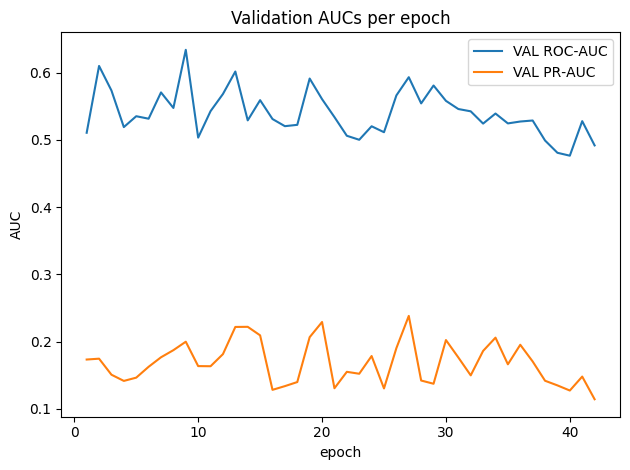

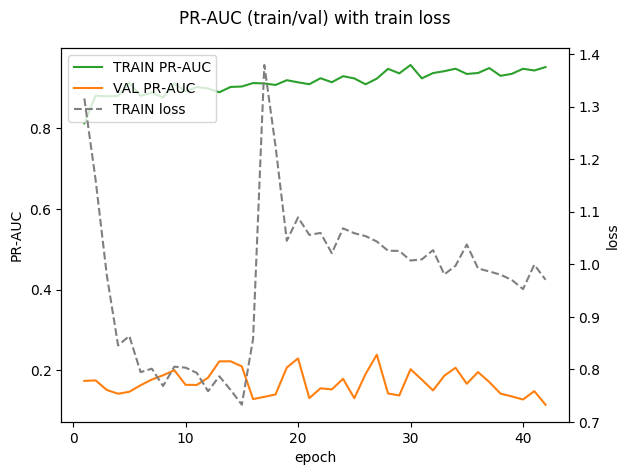

In [ ]:
#Plot PR-AUC per epoch

_ep = np.arange(1, len(history.get("train_loss", [])) + 1)


#  VAL ROC‑AUC & VAL PR‑AUC across epochs
plt.figure()
plt.plot(_ep, history.get("val_auc", []), label="VAL ROC‑AUC", color="tab:blue")
plt.plot(_ep, history.get("val_prauc", []), label="VAL PR‑AUC", color="tab:orange")
plt.xlabel("epoch"); plt.ylabel("AUC"); plt.title("Validation AUCs per epoch")
plt.legend(); plt.tight_layout(); plt.show()


#  Train vs Val PR‑AUC (with train loss on a twin axis)
fig, ax = plt.subplots()
ax.plot(_ep, history.get("train_prauc", []), label="TRAIN PR‑AUC", color="tab:green")
ax.plot(_ep, history.get("val_prauc", []), label="VAL PR‑AUC", color="tab:orange")
ax.set_xlabel("epoch"); ax.set_ylabel("PR‑AUC")
lns = ax.get_legend_handles_labels()
ax2 = ax.twinx()
ax2.plot(_ep, history.get("train_loss", []), linestyle="--", label="TRAIN loss", color="tab:gray")
ax2.set_ylabel("loss")
# combined legend
lns2 = ax2.get_legend_handles_labels()
ax.legend(lns[0]+lns2[0], lns[1]+lns2[1], loc="upper left")
fig.suptitle("PR‑AUC (train/val) with train loss")
plt.tight_layout(); plt.show()

In [ ]:
# === AUPRC + thresholded metrics (threshold on target‑val) ===



if average_precision_score is not None and precision_recall_curve is not None:
    try:
        # collect probabilities and labels on VAL and TEST
        p_val, y_val = collect_probs_labels(wrapper, tgt_val, CONFIG.device)
        p_tst, y_tst = collect_probs_labels(wrapper, tgt_test, CONFIG.device)

        # PR‑AUC (baseline ~ prevalence)
        auprc_val = average_precision_score(y_val, p_val)
        auprc_tst = average_precision_score(y_tst, p_tst)
        print(f"[VAL]  PR‑AUC {auprc_val:.4f} (baseline ~{y_val.mean():.3f})")
        print(f"[TEST] PR‑AUC {auprc_tst:.4f} (baseline ~{y_tst.mean():.3f})")

        # --- threshold selection ---
        #  F1‑optimal; Optional: precision‑at target via CONFIG.prec_target
        THRESH_RULE = getattr(CONFIG, "thr_rule", "f1")          # "f1" or "precision_at"
        PREC_TARGET = float(getattr(CONFIG, "prec_target", 0.60))  # used when THRESH_RULE=="precision_at"

        prec, rec, thr = precision_recall_curve(y_val, p_val)
        # prec/rec have len = len(thr)+1
        if THRESH_RULE == "precision_at":
            # find first threshold achieving the desired precision
            idx = next((i for i in range(len(prec)-1) if prec[i] >= PREC_TARGET), len(thr)-1)
            tau = float(thr[idx]) if thr.size > 0 else 0.5
            sel_info = f"precision≥{PREC_TARGET:.2f} ⇒ τ={tau:.3f}, P={prec[idx]:.3f}, R={rec[idx]:.3f}"
        else:  # F1‑optimal
            f1s = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-12)
            idx = int(np.nanargmax(f1s)) if f1s.size > 0 else 0
            tau = float(thr[idx]) if thr.size > 0 else 0.5
            sel_info = f"F1*={f1s[idx]:.3f} at τ={tau:.3f}, P={prec[idx]:.3f}, R={rec[idx]:.3f}"
        print(f"[VAL] threshold: {sel_info}")

        # Evaluate TEST at τ (threshold)
        if accuracy_score is not None:
            y_hat = (p_tst >= tau).astype(int)
            acc = accuracy_score(y_tst, y_hat)
            prc = precision_score(y_tst, y_hat, zero_division=0)
            rcl = recall_score(y_tst, y_hat)
            f1t = f1_score(y_tst, y_hat)
            print(f"[TEST@τ={tau:.3f}] acc {acc:.4f} | prec {prc:.4f} | rec {rcl:.4f} | f1 {f1t:.4f}")
            if confusion_matrix is not None:
                fcm = confusion_matrix(y_tst, y_hat, labels=[0,1])
                if fcm.size == 4:
                    tn, fp, fn, tp = fcm.ravel()
                    print(f"[TEST@τ] TN {tn} FP {fp} FN {fn} TP {tp}")
    except Exception as e:
        print(f"[WARN] PR‑AUC/threshold computation skipped: {e}")
else:
    print("[WARN] sklearn metrics for PR‑AUC/thresholding not available.")


[VAL]  PR‑AUC 0.2383 (baseline ~0.113)
[TEST] PR‑AUC 0.3222 (baseline ~0.115)
[VAL] threshold: F1*=0.286 at τ=0.635, P=0.370, R=0.233
[TEST@τ=0.635] acc 0.8639 | prec 0.3333 | rec 0.1818 | f1 0.2353
[TEST@τ] TN 161 FP 8 FN 18 TP 4


In [ ]:
#### Recall priority


import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# 1) Get probabilities/labels on VAL and TEST
p_val, y_val = collect_probs_labels(wrapper, tgt_val, CONFIG.device)
p_tst, y_tst = collect_probs_labels(wrapper, tgt_test, CONFIG.device)

# 2) Compute PR-AUCs (optional prints)
auprc_val = average_precision_score(y_val, p_val)
auprc_tst = average_precision_score(y_tst, p_tst)
print(f"[VAL]  PR-AUC {auprc_val:.4f} (baseline ~{y_val.mean():.3f})")
print(f"[TEST] PR-AUC {auprc_tst:.4f} (baseline ~{y_tst.mean():.3f})")

# 3) Recall-target threshold on VAL
RECALL_TARGET = float(getattr(CONFIG, "recall_target", 0.75))
prec_v, rec_v, thr_v = precision_recall_curve(y_val, p_val)
# score candidates: precision for points with recall>=target, else -1
_scores = (rec_v[:-1] >= RECALL_TARGET).astype(float) * (prec_v[:-1] + 1e-12) \
        + (rec_v[:-1] <  RECALL_TARGET).astype(float) * (-1.0)
_idx = int(np.argmax(_scores))
_tau_rec = float(thr_v[_idx])
print(f"[VAL] recall≥{RECALL_TARGET:.2f} → τ={_tau_rec:.3f}, P={prec_v[_idx]:.3f}, R={rec_v[_idx]:.3f}")

# 4) TEST metrics @ τ
_y_hat = (p_tst >= _tau_rec).astype(int)
_acc = accuracy_score(y_tst, _y_hat)
_prc = precision_score(y_tst, _y_hat, zero_division=0)
_rcl = recall_score(y_tst, _y_hat)
_f1  = f1_score(y_tst, _y_hat)
_cm  = confusion_matrix(y_tst, _y_hat, labels=[0,1])
print(f"[TEST@τ={_tau_rec:.3f}] acc {_acc:.4f} | prec {_prc:.4f} | rec {_rcl:.4f} | f1 {_f1:.4f}")
if _cm.size == 4:
    tn, fp, fn, tp = _cm.ravel()
    print(f"[TEST@τ] TN {tn} FP {fp} FN {fn} TP {tp} | flagged {fp+tp}/{len(y_tst)} = {(fp+tp)/len(y_tst):.2%}")


# === Logging & Summary CSV


import os
import math
import time
from datetime import datetime

#  helper to push constant meta into history each epoch ----------
def _log_const_meta_each_epoch(history, CONFIG, epoch_idx, lam_value):
    """Append constant run parameters each epoch so they appear in the per‑epoch CSV.
    lam_value is the GRL lambda used this epoch.
    """
    meta = {
        "run_name": globals().get("RUN_NAME", "cross_modal"),
        "epoch": int(epoch_idx),
        "source": getattr(CONFIG, "source_flag", ""),
        "target": getattr(CONFIG, "target_flag", ""),
        "batch_size": getattr(CONFIG, "batch_size", None),
        "epochs_cfg": getattr(CONFIG, "epochs", None),
        "lr": getattr(CONFIG, "lr", None),
        "weight_decay": getattr(CONFIG, "weight_decay", None),
        "lam_max": getattr(CONFIG, "lam_max", None),
        "lambda_warmup": getattr(CONFIG, "lambda_warmup", None),
        "alpha_entropy": getattr(CONFIG, "alpha_entropy", None),
        "mu_coral": getattr(CONFIG, "mu_coral", None),
        "feat_layer_name": getattr(CONFIG, "feat_layer_name", ""),
        "seed": getattr(CONFIG, "seed", None),
        "thr_rule": getattr(CONFIG, "thr_rule", ""),
        "recall_target": getattr(CONFIG, "recall_target", None),
        "f_beta": getattr(CONFIG, "f_beta", None),
        "prec_target": getattr(CONFIG, "prec_target", None),
        "grl_lambda": float(lam_value),
        "timestamp": datetime.utcnow().isoformat(timespec="seconds")
    }
    for k, v in meta.items():
        history.setdefault(k, []).append(v)



def _append_final_summary_csv(RUN_NAME, CONFIG, tau, acc, prc, rcl, f1t, cm,
                              auprc_val, auprc_tst, extra: dict = None):
    if pd is None:
        return
    csv_path = f"./history_record/{RUN_NAME}.csv"

    try:
        base = pd.read_csv(csv_path)
    except Exception:
        # fallback to empty df so we can still create a summary row
        base = pd.DataFrame()

    tn = int(cm[0,0]) if cm is not None and cm.size == 4 else None
    fp = int(cm[0,1]) if cm is not None and cm.size == 4 else None
    fn = int(cm[1,0]) if cm is not None and cm.size == 4 else None
    tp = int(cm[1,1]) if cm is not None and cm.size == 4 else None
    flagged = (fp or 0) + (tp or 0)
    total = (tn or 0) + (fp or 0) + (fn or 0) + (tp or 0)
    flagged_frac = (flagged / total) if total else float('nan')

    row = {
        "epoch": "final",
        "run_name": RUN_NAME,
        "source": getattr(CONFIG, "source_flag", ""),
        "target": getattr(CONFIG, "target_flag", ""),
        "batch_size": getattr(CONFIG, "batch_size", None),
        "epochs_cfg": getattr(CONFIG, "epochs", None),
        "lr": getattr(CONFIG, "lr", None),
        "weight_decay": getattr(CONFIG, "weight_decay", None),
        "lam_max": getattr(CONFIG, "lam_max", None),
        "lambda_warmup": getattr(CONFIG, "lambda_warmup", None),
        "alpha_entropy": getattr(CONFIG, "alpha_entropy", None),
        "mu_coral": getattr(CONFIG, "mu_coral", None),
        "feat_layer_name": getattr(CONFIG, "feat_layer_name", ""),
        "seed": getattr(CONFIG, "seed", None),
        "thr_rule": getattr(CONFIG, "thr_rule", ""),
        "recall_target": getattr(CONFIG, "recall_target", None),
        "f_beta": getattr(CONFIG, "f_beta", None),
        "prec_target": getattr(CONFIG, "prec_target", None),
        "tau": float(tau),
        "test_acc_at_tau": float(acc),
        "test_prec_at_tau": float(prc),
        "test_rec_at_tau": float(rcl),
        "test_f1_at_tau": float(f1t),
        "test_tn": tn, "test_fp": fp, "test_fn": fn, "test_tp": tp,
        "flagged_frac": flagged_frac,
        "val_prauc_final": float(auprc_val) if auprc_val is not None else float('nan'),
        "test_prauc_final": float(auprc_tst) if auprc_tst is not None else float('nan'),
        "timestamp": datetime.utcnow().isoformat(timespec="seconds")
    }
    if extra:
        row.update(extra)

    out = pd.concat([base, pd.DataFrame([row])], ignore_index=True)
    out.to_csv(csv_path, index=False)
    print(f"[INFO] Appended final summary to {csv_path}")

    _append_final_summary_csv(RUN_NAME, CONFIG, tau, acc, prc, rcl, f1t, cm,
                          auprc_val=auprc_val, auprc_tst=auprc_tst)



[VAL]  PR-AUC 0.2383 (baseline ~0.113)
[TEST] PR-AUC 0.3222 (baseline ~0.115)
[VAL] recall≥0.75 → τ=0.112, P=0.144, R=0.767
[TEST@τ=0.112] acc 0.5131 | prec 0.1858 | rec 0.9545 | f1 0.3111
[TEST@τ] TN 77 FP 92 FN 1 TP 21 | flagged 113/191 = 59.16%


In [ ]:
# 1) Class counts (target val/test)
from collections import Counter
def count_classes(ds):
    c=Counter()
    for i in range(len(ds.ds)):
        _, y = ds.ds[i]
        c.update([int(np.array(y).squeeze())])
    return dict(c)

print("VAL class counts:", count_classes(tgt_val.dataset))
print("TEST class counts:", count_classes(tgt_test.dataset))

VAL class counts: {1: 43, 0: 339}
TEST class counts: {1: 22, 0: 169}


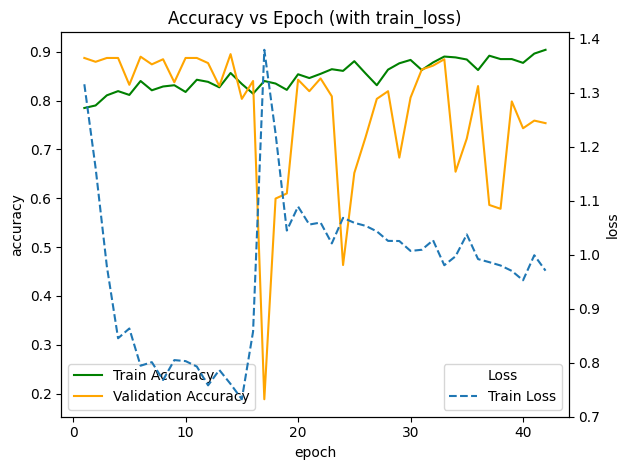

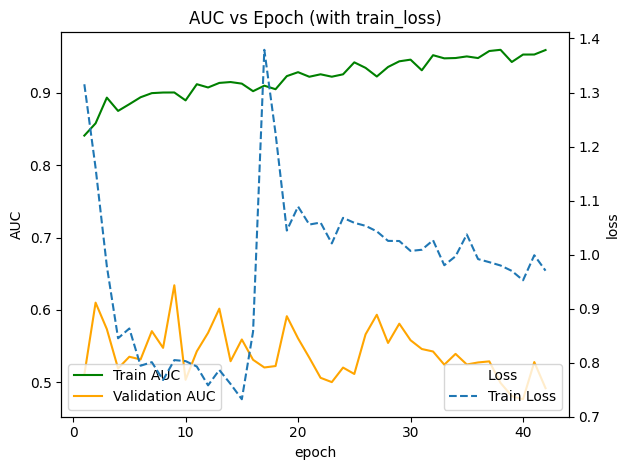

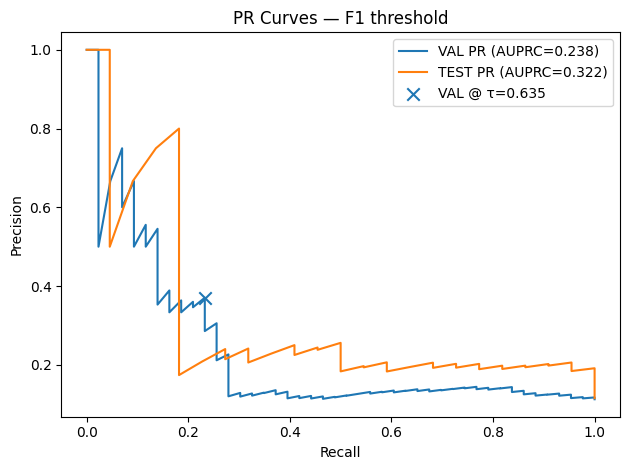

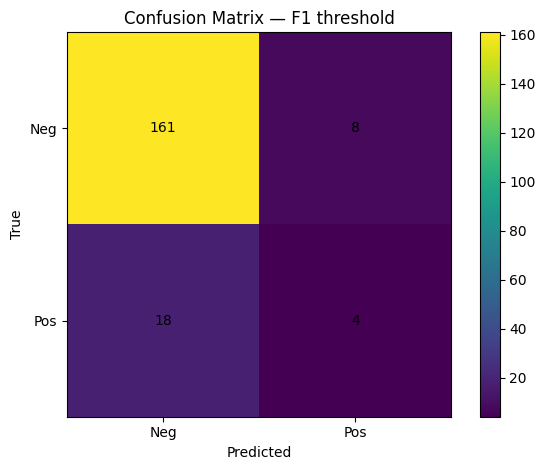

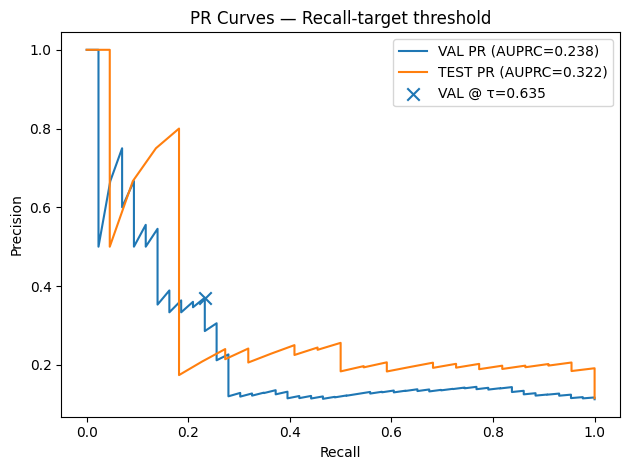

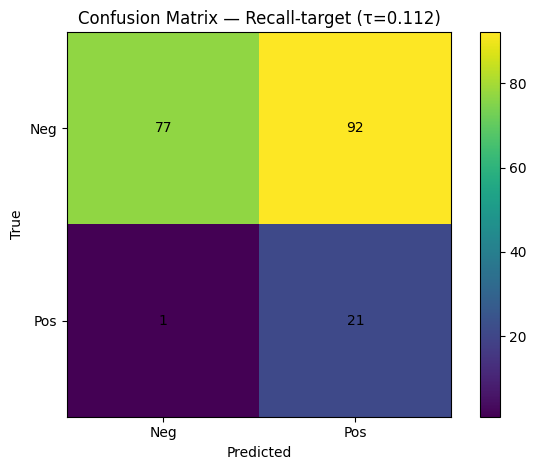

In [ ]:
# =====================
#  Epoch Curves (reuse existing `history`)

import numpy as np
import matplotlib.pyplot as plt

# --- Consistent colors ---
COL_TRAIN = "green"   # train = green
COL_VAL   = "orange"  # val   = orange

# ===== Accuracy vs Epoch (with train_loss) =====
_ep = np.arange(1, len(history.get("train_loss", [])) + 1)

fig, ax = plt.subplots()
# accuracy on LEFT axis (colors fixed)
ax.plot(_ep, history.get("train_acc", []), label="Train Accuracy", color=COL_TRAIN)
ax.plot(_ep, history.get("val_acc", []),   label="Validation Accuracy", color=COL_VAL)
ax.set_xlabel("epoch"); ax.set_ylabel("accuracy")
ax.legend(loc="lower left")

# loss on RIGHT axis (keep default color or pick one if you want)
ax2 = ax.twinx()
ax2.plot(_ep, history.get("train_loss", []), linestyle="--", label="Train Loss")
ax2.set_ylabel("loss")
ax2.legend(loc="lower right", title="Loss")

ax.set_title("Accuracy vs Epoch (with train_loss)")
plt.tight_layout(); plt.show()

# ===== AUC vs Epoch (with train_loss) =====
fig, ax = plt.subplots()
# AUC on LEFT axis (colors fixed)
ax.plot(_ep, history.get("train_auc", []), label="Train AUC", color=COL_TRAIN)
ax.plot(_ep, history.get("val_auc", []),   label="Validation AUC", color=COL_VAL)
ax.set_xlabel("epoch"); ax.set_ylabel("AUC")
ax.legend(loc="lower left")

# loss on RIGHT axis
ax2 = ax.twinx()
ax2.plot(_ep, history.get("train_loss", []), linestyle="--", label="Train Loss")
ax2.set_ylabel("loss")
ax2.legend(loc="lower right", title="Loss")

ax.set_title("AUC vs Epoch (with train_loss)")
plt.tight_layout(); plt.show()

# =====================


from sklearn.metrics import precision_recall_curve, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, average_precision_score

# PR curves with F1-opt point marked
plt.figure()
plt.plot(rec, prec, label=f"VAL PR (AUPRC={auprc_val:.3f})")
_prec_t, _rec_t, _ = precision_recall_curve(y_tst, p_tst)
plt.plot(_rec_t, _prec_t, label=f"TEST PR (AUPRC={auprc_tst:.3f})")
plt.scatter([rec[idx]], [prec[idx]], marker="x", s=80, label=f"VAL @ τ={tau:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR Curves — F1 threshold")
plt.legend(loc="best"); plt.tight_layout(); plt.show()

# Confusion matrix heatmap on TEST @ τ
_y_hat = (p_tst >= tau).astype(int)
_fcm = confusion_matrix(y_tst, _y_hat, labels=[0,1])
fig, ax = plt.subplots()
im = ax.imshow(_fcm)
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(["Neg","Pos"]); ax.set_yticklabels(["Neg","Pos"])
for r in range(2):
    for c in range(2):
        ax.text(c, r, int(_fcm[r, c]), ha="center", va="center")
ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title("Confusion Matrix — F1 threshold")
plt.colorbar(im); plt.tight_layout(); plt.show()


#  **recall threshold** block


# PR curves with recall-target point marked
plt.figure()
plt.plot(rec, prec, label=f"VAL PR (AUPRC={auprc_val:.3f})")
_prec_t2, _rec_t2, _ = precision_recall_curve(y_tst, p_tst)
plt.plot(_rec_t2, _prec_t2, label=f"TEST PR (AUPRC={auprc_tst:.3f})")
# find the index "j" on VAL where thr == tau (closest)
import numpy as _np
_j = int(_np.argmin(_np.abs(thr - tau))) if len(thr) else 0
plt.scatter([rec[_j]], [prec[_j]], marker="x", s=80, label=f"VAL @ τ={tau:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR Curves — Recall-target threshold")
plt.legend(loc="best"); plt.tight_layout(); plt.show()

# Heatmap for recall-target confusion matrix (_cm)
fig, ax = plt.subplots()
im = ax.imshow(_cm)  # _cm from: _cm = confusion_matrix(y_tst, _y_hat, labels=[0,1])
ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
ax.set_xticklabels(["Neg", "Pos"]); ax.set_yticklabels(["Neg", "Pos"])
for r in range(2):
    for c in range(2):
        ax.text(c, r, int(_cm[r, c]), ha="center", va="center")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_title(f"Confusion Matrix — Recall-target (τ={_tau_rec:.3f})")
plt.colorbar(im, ax=ax)
plt.tight_layout(); plt.show()
